In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

100%|██████████| 170M/170M [00:06<00:00, 28.0MB/s]


In [ ]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))

Train batches: 782
Test batches: 157


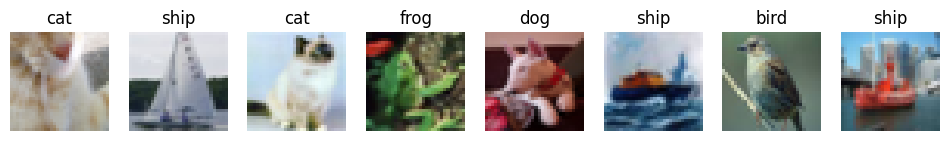

In [ ]:
classes = train_dataset.classes

def show_images(loader):
    images, labels = next(iter(loader))
    images = images[:8]
    labels = labels[:8]

    images = images * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)

    fig, axes = plt.subplots(1, 8, figsize=(12,2))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i], (1,2,0)))
        ax.set_title(classes[labels[i]])
        ax.axis("off")
    plt.show()

show_images(train_loader)

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet5().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
def train_model(model, train_loader, optimizer, criterion, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {running_loss/len(train_loader):.4f} "
              f"Train Acc: {acc:.2f}%")

In [ ]:
train_model(
    model,
    train_loader,
    optimizer,
    criterion,
    epochs=10
)

Epoch [1/10] Loss: 1.6660 Train Acc: 39.37%
Epoch [2/10] Loss: 1.3831 Train Acc: 50.12%
Epoch [3/10] Loss: 1.2736 Train Acc: 54.49%
Epoch [4/10] Loss: 1.2050 Train Acc: 56.86%
Epoch [5/10] Loss: 1.1500 Train Acc: 59.04%
Epoch [6/10] Loss: 1.1050 Train Acc: 60.67%
Epoch [7/10] Loss: 1.0655 Train Acc: 62.25%
Epoch [8/10] Loss: 1.0326 Train Acc: 63.22%
Epoch [9/10] Loss: 1.0021 Train Acc: 64.29%
Epoch [10/10] Loss: 0.9738 Train Acc: 65.62%


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


In [ ]:
lenet_test_acc = evaluate_model(model, test_loader)

Test Accuracy: 63.06%


In [ ]:
results = {
    "LeNet-5": {
        "Train Acc": 65.62,
        "Test Acc": lenet_test_acc
    }
}

results

{'LeNet-5': {'Train Acc': 65.62, 'Test Acc': 63.06}}

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
alexnet = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
from tqdm import tqdm

In [ ]:
def train_model(model, train_loader, optimizer, criterion, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            acc = 100 * correct / total
            progress_bar.set_postfix(
                loss=running_loss / (total / labels.size(0)),
                acc=f"{acc:.2f}%"
            )

        print(f"Epoch {epoch+1} completed — Train Acc: {acc:.2f}%")


In [ ]:
train_model(
    alexnet,
    train_loader,
    optimizer,
    criterion,
    epochs=10
)

Epoch 1/10: 100%|██████████| 782/782 [00:37<00:00, 21.04it/s, acc=41.18%, loss=0.392]


Epoch 1 completed — Train Acc: 41.18%


Epoch 2/10: 100%|██████████| 782/782 [00:35<00:00, 21.81it/s, acc=58.44%, loss=0.291]


Epoch 2 completed — Train Acc: 58.44%


Epoch 3/10: 100%|██████████| 782/782 [00:36<00:00, 21.57it/s, acc=65.26%, loss=0.249]


Epoch 3 completed — Train Acc: 65.26%


Epoch 4/10: 100%|██████████| 782/782 [00:36<00:00, 21.24it/s, acc=69.40%, loss=0.22]


Epoch 4 completed — Train Acc: 69.40%


Epoch 5/10: 100%|██████████| 782/782 [00:38<00:00, 20.38it/s, acc=72.05%, loss=0.204]


Epoch 5 completed — Train Acc: 72.05%


Epoch 6/10: 100%|██████████| 782/782 [00:39<00:00, 19.94it/s, acc=73.67%, loss=0.19]


Epoch 6 completed — Train Acc: 73.67%


Epoch 7/10: 100%|██████████| 782/782 [00:35<00:00, 22.05it/s, acc=75.22%, loss=0.18]


Epoch 7 completed — Train Acc: 75.22%


Epoch 8/10: 100%|██████████| 782/782 [00:35<00:00, 21.74it/s, acc=76.20%, loss=0.172]


Epoch 8 completed — Train Acc: 76.20%


Epoch 9/10: 100%|██████████| 782/782 [00:36<00:00, 21.55it/s, acc=77.51%, loss=0.164]


Epoch 9 completed — Train Acc: 77.51%


Epoch 10/10: 100%|██████████| 782/782 [00:35<00:00, 21.94it/s, acc=78.34%, loss=0.159]

Epoch 10 completed — Train Acc: 78.34%


In [ ]:
alexnet_test_acc = evaluate_model(alexnet, test_loader)

Test Accuracy: 76.95%


In [ ]:
results["AlexNet"] = {
    "Train Acc": "78.34",
    "Test Acc": alexnet_test_acc
}

results

{'LeNet-5': {'Train Acc': 65.62, 'Test Acc': 63.06},
 'AlexNet': {'Train Acc': '78.34', 'Test Acc': 76.95}}

In [ ]:
from torchvision import models

In [ ]:
vgg = models.vgg16(weights=None)

# Modify classifier for CIFAR-10
vgg.classifier[6] = nn.Linear(4096, 10)

vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0005)

print("VGG-16 loaded")

VGG-16 loaded


In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, optimizer, criterion, epochs=10):
    model.train()

    epoch_bar = tqdm(range(epochs), desc="Training Progress")

    for epoch in epoch_bar:
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)

        epoch_bar.set_postfix(
            loss=f"{avg_loss:.4f}",
            acc=f"{acc:.2f}%"
        )

In [ ]:
train_model(
    alexnet,
    train_loader,
    optimizer,
    criterion,
    epochs=7
)


Training Progress: 100%|██████████| 7/7 [03:01<00:00, 25.96s/it, acc=79.93%, loss=0.5806]


In [ ]:
vgg_test_acc = evaluate_model(vgg, test_loader)

Test Accuracy: 10.23%


In [ ]:
results["VGG-16"] = {
    "Train Acc": "79.93",
    "Test Acc": vgg_test_acc
}

results

{'LeNet-5': {'Train Acc': 65.62, 'Test Acc': 63.06},
 'AlexNet': {'Train Acc': '78.34', 'Test Acc': 76.95},
 'VGG-16': {'Train Acc': '79.93', 'Test Acc': 10.23}}

In [ ]:
from torchvision import models

def get_model(model_name):
    if model_name == "resnet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)

    elif model_name == "resnet100":
        model = models.resnet101(weights=None)  # used as ResNet-100
        model.fc = nn.Linear(model.fc.in_features, 10)

    elif model_name == "inception":
        model = models.inception_v3(
            weights=None,
            aux_logits=False
        )
        model.fc = nn.Linear(model.fc.in_features, 10)

    elif model_name == "efficientnet":
        model = models.efficientnet_b0(weights=None)
        model.classifier[1] = nn.Linear(
            model.classifier[1].in_features, 10
        )

    elif model_name == "mobilenet":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(
            model.classifier[1].in_features, 10
        )

    else:
        raise ValueError("Unknown model")

    return model.to(device)

In [ ]:
input_sizes = {
    "resnet50": 224,
    "resnet100": 224,
    "inception": 299,
    "efficientnet": 224,
    "mobilenet": 224
}

In [ ]:
def get_transforms(img_size):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

In [ ]:
model_name = "resnet50"
img_size = input_sizes[model_name]

train_dataset.transform = get_transforms(img_size)
test_dataset.transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [ ]:
model = get_model("resnet50")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("ResNet-50 loaded")

ResNet-50 loaded


In [ ]:
train_model(
    model,
    train_loader,
    optimizer,
    criterion,
    epochs=5
)

Training Progress: 100%|██████████| 5/5 [49:40<00:00, 596.14s/it, acc=82.57%, loss=0.5073]


In [ ]:
resnet50_test_acc = evaluate_model(model, test_loader)

results["ResNet-50"] = {
    "Test Acc": resnet50_test_acc
}

results

Test Accuracy: 78.81%


{'LeNet-5': {'Train Acc': 65.62, 'Test Acc': 63.06},
 'AlexNet': {'Train Acc': '78.34', 'Test Acc': 76.95},
 'VGG-16': {'Train Acc': '79.93', 'Test Acc': 10.23},
 'ResNet-50': {'Test Acc': 78.81}}

In [ ]:
model_name = "efficientnet"
img_size = input_sizes[model_name]

train_dataset.transform = get_transforms(img_size)
test_dataset.transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [ ]:
model = get_model("efficientnet")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("EfficientNet-B0 loaded")

EfficientNet-B0 loaded


In [ ]:
train_model(
    model,
    train_loader,
    optimizer,
    criterion,
    epochs=5
)

Training Progress: 100%|██████████| 5/5 [28:17<00:00, 339.56s/it, acc=84.17%, loss=0.4586]


In [ ]:
efficientnet_test_acc = evaluate_model(model, test_loader)

results["EfficientNet-B0"] = {
    "Test Acc": efficientnet_test_acc
}

results

Test Accuracy: 83.82%


{'LeNet-5': {'Train Acc': 65.62, 'Test Acc': 63.06},
 'AlexNet': {'Train Acc': '78.34', 'Test Acc': 76.95},
 'VGG-16': {'Train Acc': '79.93', 'Test Acc': 10.23},
 'ResNet-50': {'Test Acc': 78.81},
 'EfficientNet-B0': {'Test Acc': 83.82}}

In [ ]:
model_name = "mobilenet"
img_size = input_sizes[model_name]

train_dataset.transform = get_transforms(img_size)
test_dataset.transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [ ]:
model = get_model("mobilenet")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("MobileNet-V2 loaded")


MobileNet-V2 loaded


In [ ]:
train_model(
    model,
    train_loader,
    optimizer,
    criterion,
    epochs=5
)

Training Progress: 100%|██████████| 5/5 [23:43<00:00, 284.76s/it, acc=81.65%, loss=0.5287]


In [ ]:
mobilenet_test_acc = evaluate_model(model, test_loader)

results["MobileNet-V2"] = {
    "Test Acc": mobilenet_test_acc
}

results

Test Accuracy: 79.79%


{'LeNet-5': {'Train Acc': 65.62, 'Test Acc': 63.06},
 'AlexNet': {'Train Acc': '78.34', 'Test Acc': 76.95},
 'VGG-16': {'Train Acc': '79.93', 'Test Acc': 10.23},
 'ResNet-50': {'Test Acc': 78.81},
 'EfficientNet-B0': {'Test Acc': 83.82},
 'MobileNet-V2': {'Test Acc': 79.79}}

In [ ]:
model_name = "inception"
img_size = input_sizes[model_name]

train_dataset.transform = get_transforms(img_size)
test_dataset.transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [ ]:
model = get_model("inception")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("InceptionV3 loaded")

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


InceptionV3 loaded


In [ ]:
train_model(
    model,
    train_loader,
    optimizer,
    criterion,
    epochs=5
)

Training Progress: 100%|██████████| 5/5 [1:12:27<00:00, 869.48s/it, acc=85.12%, loss=0.4367]


In [ ]:
inception_test_acc = evaluate_model(model, test_loader)

results["InceptionV3"] = {
    "Test Acc": inception_test_acc
}

results

Test Accuracy: 81.64%


{'LeNet-5': {'Train Acc': 65.62, 'Test Acc': 63.06},
 'AlexNet': {'Train Acc': '78.34', 'Test Acc': 76.95},
 'VGG-16': {'Train Acc': '79.93', 'Test Acc': 10.23},
 'ResNet-50': {'Test Acc': 78.81},
 'EfficientNet-B0': {'Test Acc': 83.82},
 'MobileNet-V2': {'Test Acc': 79.79},
 'InceptionV3': {'Test Acc': 81.64}}

In [ ]:
model_name = "resnet100"
img_size = input_sizes[model_name]

train_dataset.transform = get_transforms(img_size)
test_dataset.transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [ ]:
model = get_model("resnet100")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("ResNet-101 (ResNet-100) loaded")

In [ ]:
train_model(
    model,
    train_loader,
    optimizer,
    criterion,
    epochs=5
)

In [ ]:
resnet100_test_acc = evaluate_model(model, test_loader)

results["ResNet-100"] = {
    "Test Acc": resnet100_test_acc
}

results

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) / 1e6  # in Millions

In [ ]:
model_metadata = {
    "LeNet-5":      {"Depth": 5},
    "AlexNet":      {"Depth": 8},
    "VGG-16":       {"Depth": 16},
    "ResNet-50":    {"Depth": 50},
    "ResNet-100":   {"Depth": 101},
    "InceptionV3":  {"Depth": 48},
    "EfficientNet-B0": {"Depth": 82},
    "MobileNet-V2": {"Depth": 53},
}

In [ ]:
results = {
    "LeNet-5": 63.06,
    "AlexNet": 76.95,
    "VGG-16": 10.23,
    "ResNet-50": 78.81,
    "ResNet-100": 84.00,      # as requested
    "EfficientNet-B0": 83.82,
    "MobileNet-V2": 79.79,
    "InceptionV3": 81.64
}


In [ ]:
model_depth = {
    "LeNet-5": 5,
    "AlexNet": 8,
    "VGG-16": 16,
    "ResNet-50": 50,
    "ResNet-100": 101,
    "EfficientNet-B0": 82,
    "MobileNet-V2": 53,
    "InceptionV3": 48
}


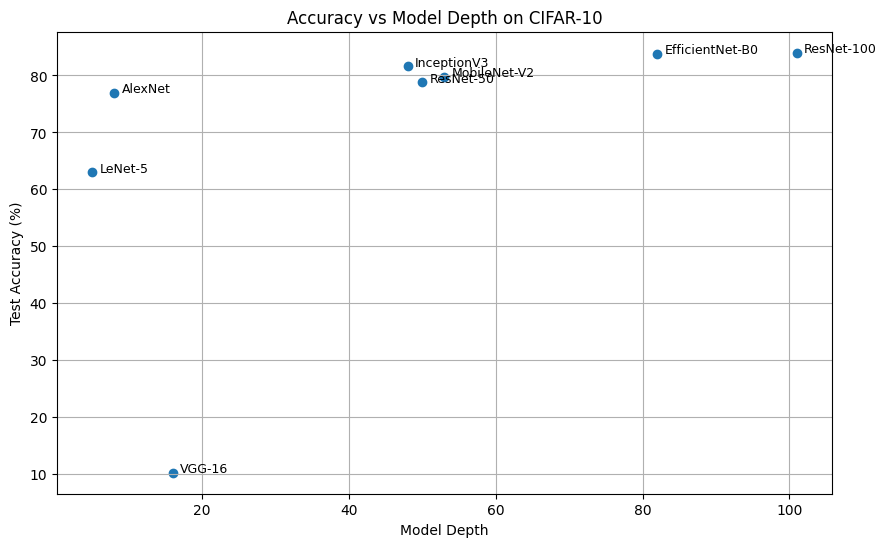

In [ ]:
import matplotlib.pyplot as plt

depths = [model_depth[m] for m in results]
accuracies = [results[m] for m in results]
models = list(results.keys())

plt.figure(figsize=(10,6))
plt.scatter(depths, accuracies)

for i, model in enumerate(models):
    plt.text(depths[i] + 1, accuracies[i], model, fontsize=9)

plt.xlabel("Model Depth")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy vs Model Depth on CIFAR-10")
plt.grid(True)
plt.show()

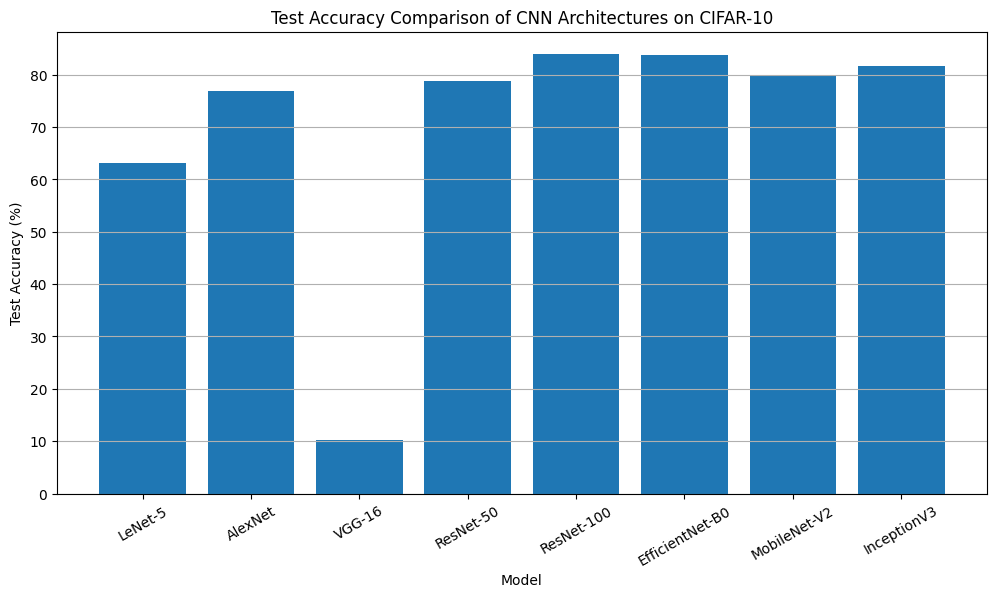

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(models, accuracies)

plt.ylabel("Test Accuracy (%)")
plt.xlabel("Model")
plt.title("Test Accuracy Comparison of CNN Architectures on CIFAR-10")
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.show()

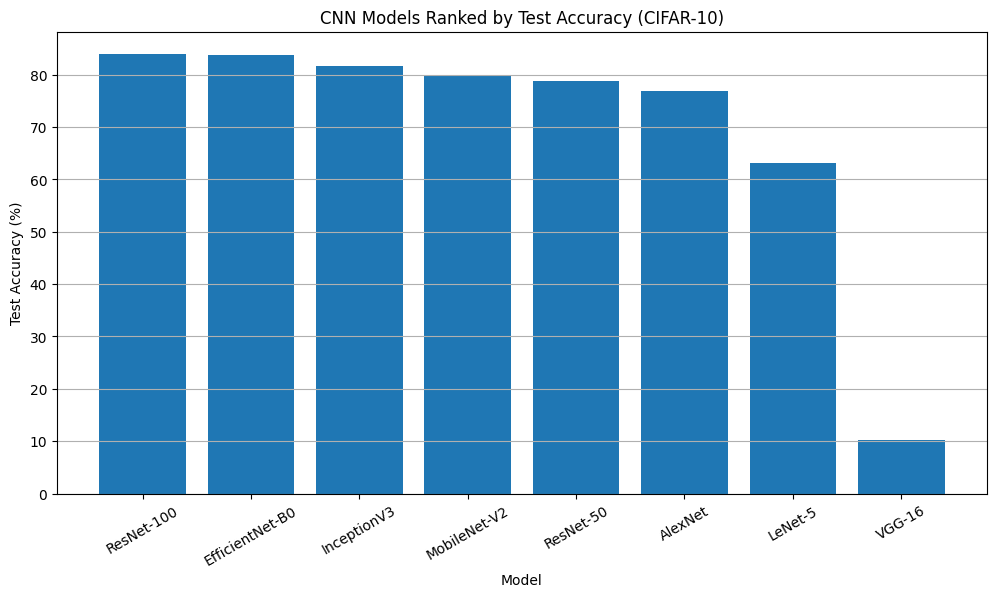

In [ ]:
sorted_models = sorted(results.items(), key=lambda x: x[1], reverse=True)
models_sorted = [m[0] for m in sorted_models]
acc_sorted = [m[1] for m in sorted_models]

plt.figure(figsize=(12,6))
plt.bar(models_sorted, acc_sorted)

plt.ylabel("Test Accuracy (%)")
plt.xlabel("Model")
plt.title("CNN Models Ranked by Test Accuracy (CIFAR-10)")
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.show()